**Eluvio Data Challenge**

**Data**: News headlines dataset from 2008-01-25 to 2016-11-22, including time created, upvotes, authors, over_18 (Whether or not the thread has been marked as NSFW).

**What I want to learn from the data:**

Statistics on the posts, number of posts with time(time,day,month,year) most mentioned countries, top words used in news title etc. Finding which time to post the news article.

Classification of news: over_18 or not based on news title.

**What I did in the notebook:**

1) Data Cleaning

2) Feature Exploration & Visualization: Number of post vs time, best time to post news etc. wordcloud of news based on over_18 column.

3) Classification: Applied traditional ML algorithms like Multinomial Naive Bayes, Support Vector Machine, Logistic Regression etc. Applied word embedding and Deep Learning Models to get higher accuaracy.


In [881]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
%matplotlib inline

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Machine Learning libraries
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#keras libraries
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter



###Loading Data & Cleaning

In [882]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [883]:
path = "drive/My Drive/Eluvio_DS_Challenge.csv"
news = pd.read_csv(path)

In [884]:
"""
For data which we cannot load on available memory we can use spark to do operation and store data on different nodes in a cluster.
But due to limitation of time and resource, i will use pandas DataFrame for operations and storage.
"""
#from pyspark.sql import SQLContext
#from pyspark import SparkContext
#from pyspark.sql import Row
#sc = SparkContext('local','example')
#sql_c = SQLContext(sc) 
#news = sql_c.read.csv(path,header=True)

'\nFor data which we cannot load on available memory we can use spark to do operation and store data on different nodes in a cluster.\nBut due to limitation of time and resource, i will use pandas DataFrame for operations and storage.\n'

In [885]:
news.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [886]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


No null values.



In [ ]:
news.describe()

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341585e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


up_votes have outlier with value 21253 which can be removed for better model training.

In [887]:
# adding year, month, day, time_of_the_day for easy usage in visualization
news['time_created'] = pd.to_datetime(news['time_created'], unit='s')
news['date_created'] = pd.to_datetime(news['date_created'])
news['year'] = news['date_created'].dt.year
news['month'] = news['date_created'].dt.month
news['day'] = news['date_created'].dt.day_name()
news['time_of_the_day'] = news['time_created'].dt.strftime('%H')

news.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,year,month,day,time_of_the_day
0,2008-01-25 03:34:06,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,2008,1,Friday,03
1,2008-01-25 03:34:35,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,2008,1,Friday,03
2,2008-01-25 03:42:03,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,2008,1,Friday,03
3,2008-01-25 03:54:50,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,2008,1,Friday,03
4,2008-01-25 15:25:20,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,2008,1,Friday,15


In [888]:
print(len(set(news['category'])))  # the number of author
print(len(set(news['down_votes'])))  # the number of unique down_votes

1
1


In [889]:
# Dropping category and down_votes as they have same values.
news.drop(columns=["date_created","down_votes","category"], axis = 1, inplace = True)

In [890]:
#Creating a copy and cleaning the title field
clean_news=news.copy()
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
clean_news['title']=clean_news['title'].apply(lambda x:review_cleaning(x))
clean_news.head()

,time_created,up_votes,title,over_18,author,year,month,day,time_of_the_day
0,2008-01-25 03:34:06,3,scores killed in pakistan clashes,False,polar,2008,1,Friday,03
1,2008-01-25 03:34:35,2,japan resumes refuelling mission,False,polar,2008,1,Friday,03
2,2008-01-25 03:42:03,3,us presses egypt on gaza border,False,polar,2008,1,Friday,03
3,2008-01-25 03:54:50,1,jumpstart economy give health care to all,False,fadi420,2008,1,Friday,03
4,2008-01-25 15:25:20,4,council of europe bashes euun terror blacklist,False,mhermans,2008,1,Friday,15


In [891]:
#removing the stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
clean_news['title'] = clean_news['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,time_created,up_votes,title,over_18,author,year,month,day,time_of_the_day
0,2008-01-25 03:34:06,3,scores killed pakistan clashes,False,polar,2008,1,Friday,03
1,2008-01-25 03:34:35,2,japan resumes refuelling mission,False,polar,2008,1,Friday,03
2,2008-01-25 03:42:03,3,us presses egypt gaza border,False,polar,2008,1,Friday,03
3,2008-01-25 03:54:50,1,jumpstart economy give health care,False,fadi420,2008,1,Friday,03
4,2008-01-25 15:25:20,4,council europe bashes euun terror blacklist,False,mhermans,2008,1,Friday,15


###  Feature Exploration & Visualization
Fig1. Barplots of the number of posts vs year.

Fig2. Barplots of the number of posts vs time of the day.

Fig3. Barplots of the number of posts vs month.

Fig4. Barplots of the number of posts vs day of the week.

Fig5. Barplots of the mean of the upvotes vs year.

Fig6. Barplots of the mean of the upvotes vs day of the week.

Fig7. Barplots of the mean of the upvotes vs time of the day.

Fig8. Top 20 words in title After removing stop words.

Fig9. Top 20 bigrams in title After removing stop words.

Fig10. Top 20 trigrams in title After removing stop words.

Fig11. WordCloud for over_18 news.

Fig12. WordCloud for not over_18 news. 

Text(0, 0.5, 'number of posts')

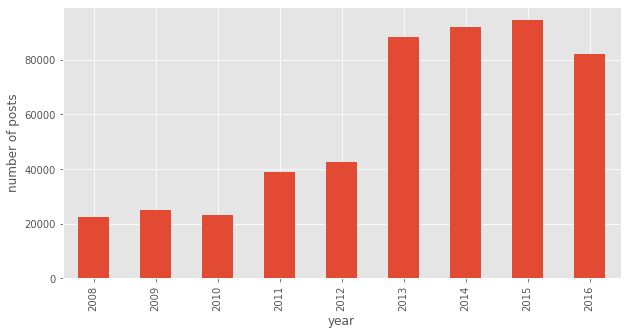

In [892]:
plt.rcParams["figure.figsize"] = (10,5)
df = clean_news.groupby(['year'])['time_created'].count()
df.plot.bar().set_ylabel('number of posts')


Text(0, 0.5, 'number of posts')

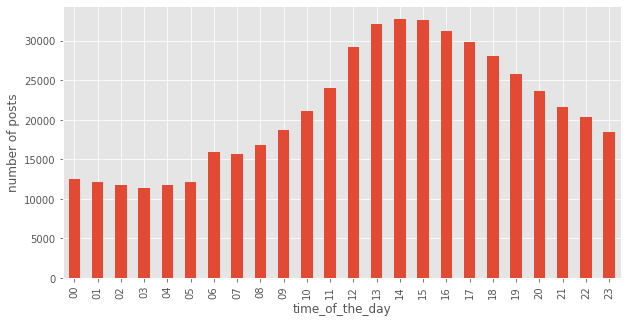

In [893]:
df = clean_news.groupby(['time_of_the_day'])['time_created'].count()
df.plot.bar().set_ylabel('number of posts')

Text(0, 0.5, 'number of posts')

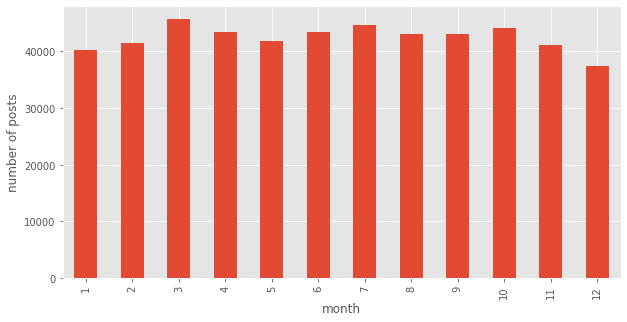

In [894]:
df = clean_news.groupby(['month'])['time_created'].count()
df.plot.bar().set_ylabel('number of posts')

Text(0, 0.5, 'number of posts')

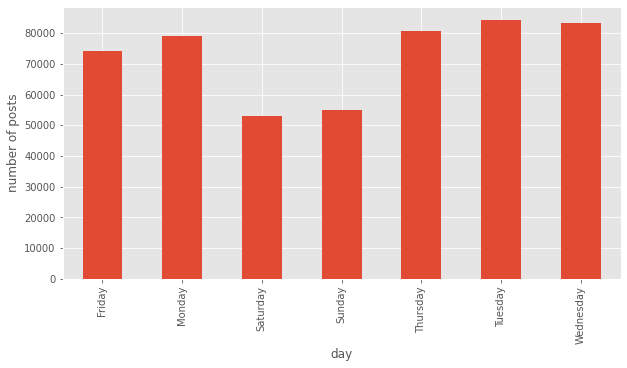

In [895]:
df = clean_news.groupby(['day'])['time_created'].count()
df.plot.bar().set_ylabel('number of posts')

Text(0, 0.5, 'avg up_votes')

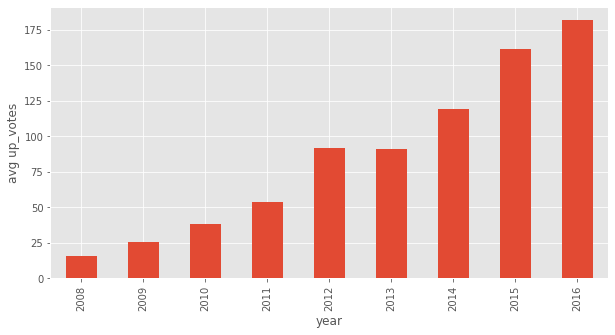

In [896]:
df = clean_news.groupby('year').mean()['up_votes']
df.plot.bar().set_ylabel('avg up_votes')

Text(0, 0.5, 'avg up_votes')

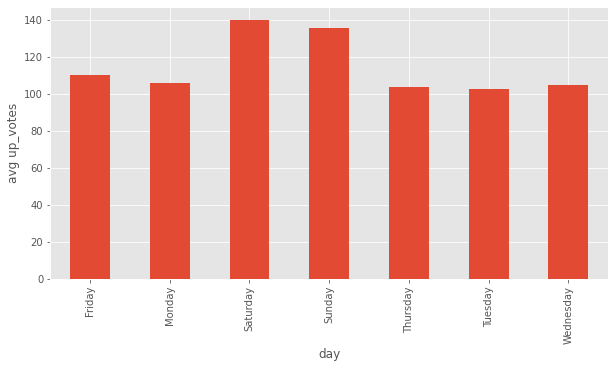

In [897]:
df = clean_news.groupby('day').mean()['up_votes']
df.plot.bar().set_ylabel('avg up_votes')

Text(0, 0.5, 'avg up_votes')

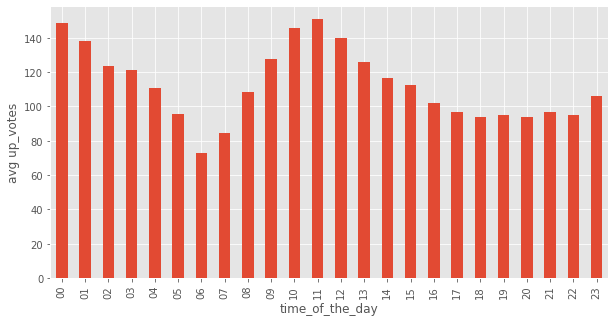

In [898]:
df = clean_news.groupby('time_of_the_day').mean()['up_votes']
df.plot.bar().set_ylabel('avg up_votes')

From above visualization of different features we can say that over the year the number of online news post are increasing. More posts are posted on weekdays at time 1 P.M to 3 P.M. Also on weekends the average upvotes of posts are highest possilbily due to holiday people read more news online. And post around 11 A.M has highest average upvotes.


In [899]:
#converting column over_18 to 0 or 1 so we can use it for training the models
le = preprocessing.LabelEncoder()
clean_news['over_18'] = le.fit_transform(clean_news['over_18'])

clean_news.head()

,time_created,up_votes,title,over_18,author,year,month,day,time_of_the_day
0,2008-01-25 03:34:06,3,scores killed pakistan clashes,0,polar,2008,1,Friday,03
1,2008-01-25 03:34:35,2,japan resumes refuelling mission,0,polar,2008,1,Friday,03
2,2008-01-25 03:42:03,3,us presses egypt gaza border,0,polar,2008,1,Friday,03
3,2008-01-25 03:54:50,1,jumpstart economy give health care,0,fadi420,2008,1,Friday,03
4,2008-01-25 15:25:20,4,council europe bashes euun terror blacklist,0,mhermans,2008,1,Friday,15


In [900]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(clean_news['title'], 20)

us 39440
china 25751
says 25401
new 23307
syria 18767
russia 18096
world 17854
police 16569
iran 15453
israel 15437
government 15384
president 14694
killed 14309
people 13912
attack 12810
state 12548
un 12399
war 12314
uk 12025
military 11655


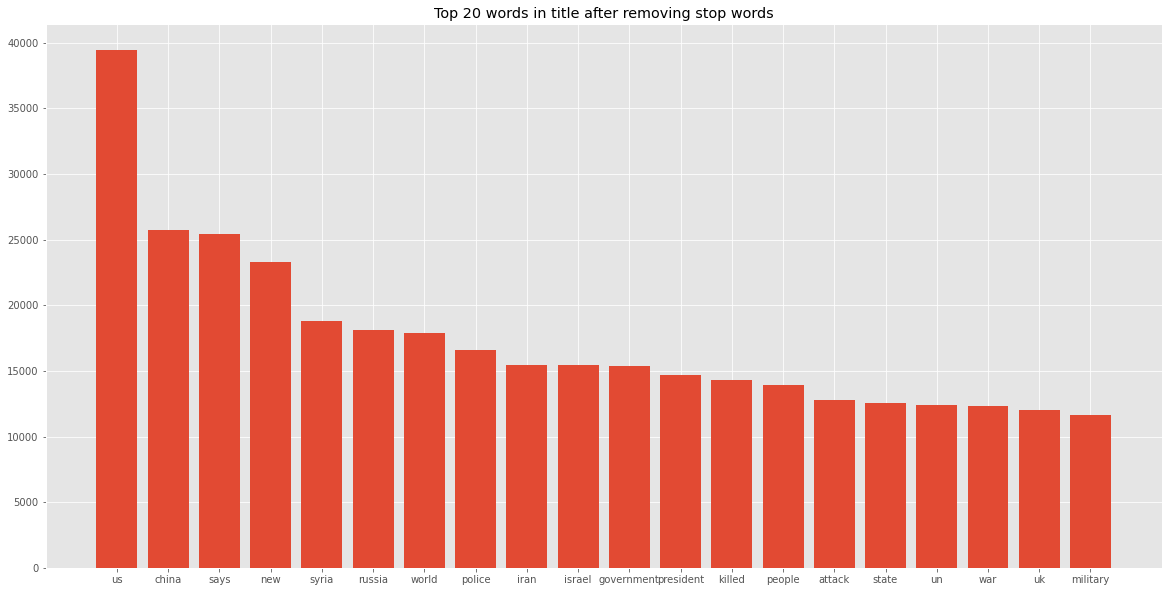

In [901]:
plt.rcParams["figure.figsize"] = (20,10)
for word, freq in common_words:
    print(word, freq)
plt.bar([v[0] for v in common_words], [v[1] for v in common_words])
plt.title('Top 20 words in title after removing stop words')
plt.show()

In [902]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_bigram = get_top_n_bigram(clean_news['title'], 20)

north korea 7061
islamic state 5197
prime minister 4732
bbc news 4147
human rights 3500
saudi arabia 3466
south korea 2645
climate change 2234
united states 2201
hong kong 2046
middle east 1808
china sea 1740
first time 1738
west bank 1729
boko haram 1661
south china 1629
south africa 1592
north korean 1516
new zealand 1507
death toll 1454


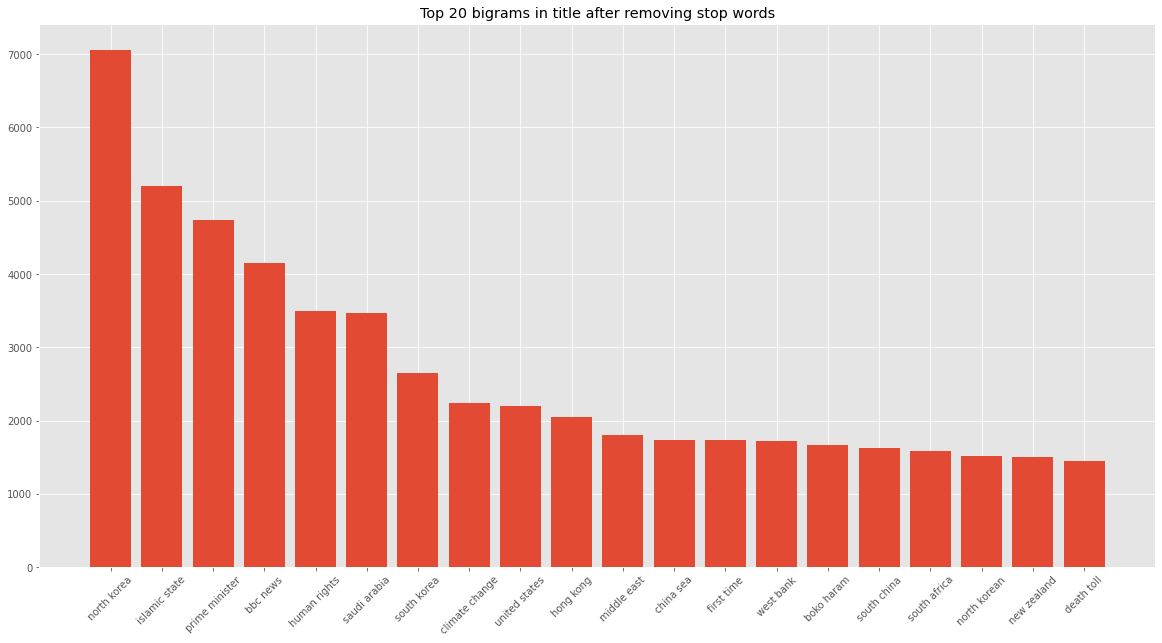

In [903]:
for word, freq in common_words_bigram:
    print(word, freq)
plt.bar([v[0] for v in common_words_bigram], [v[1] for v in common_words_bigram])
plt.title('Top 20 bigrams in title after removing stop words')
plt.xticks(rotation=45)
plt.show()

In [904]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigram = get_top_n_trigram(clean_news['title'], 20)

south china sea 1554
un security council 578
central african republic 565
kim jong un 484
al jazeera english 468
human rights watch 445
president bashar alassad 417
osama bin laden 407
president vladimir putin 383
nobel peace prize 360
new york times 348
islamic state militants 337
president barack obama 324
international criminal court 316
world war ii 312
great barrier reef 310
nuclear power plant 287
death toll rises 286
islamic state group 286
least people killed 285


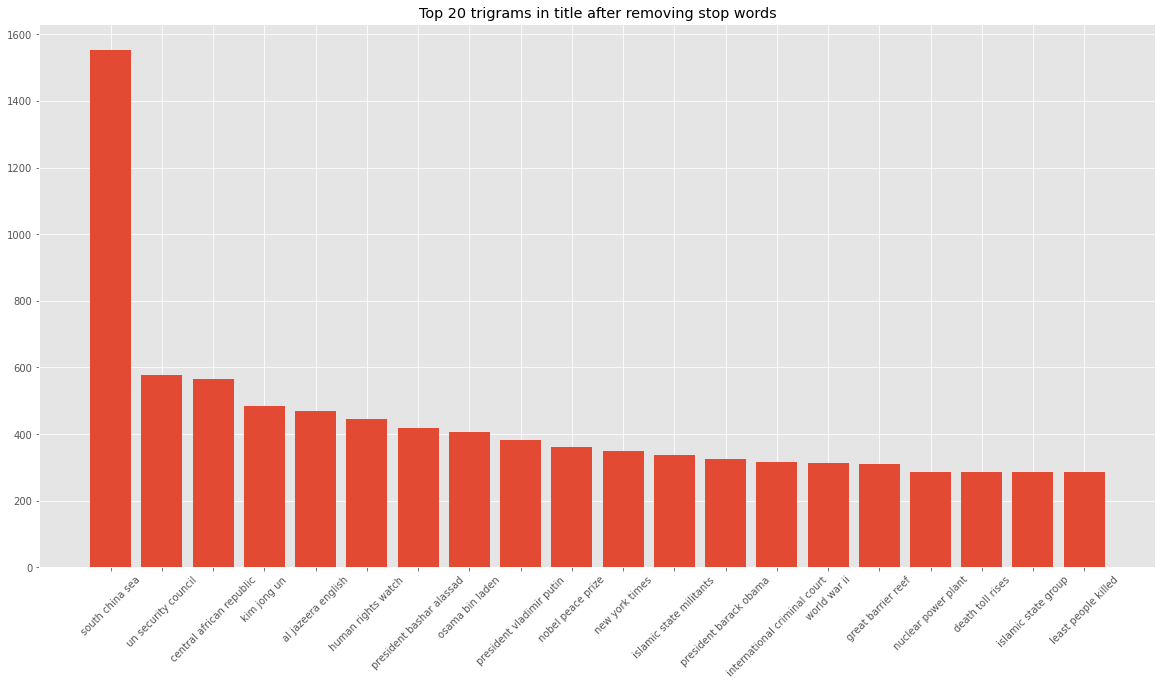

In [905]:
for word, freq in common_words_trigram:
    print(word, freq)
plt.bar([v[0] for v in common_words_trigram], [v[1] for v in common_words_trigram])
plt.title('Top 20 trigrams in title after removing stop words')
plt.xticks(rotation=45)
plt.show()

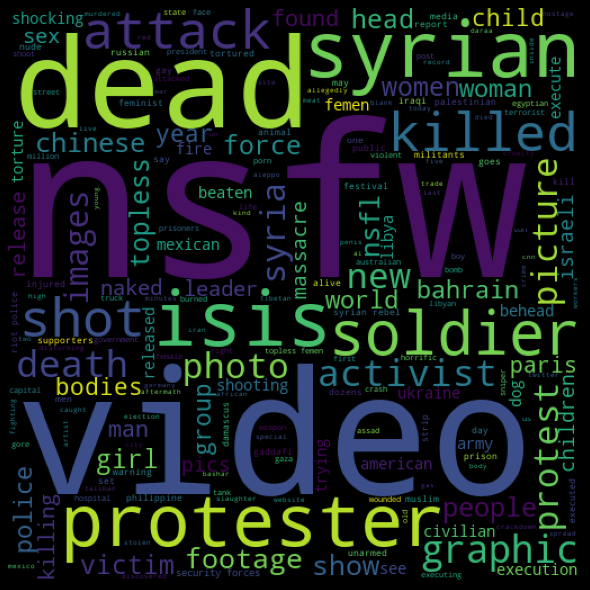

In [906]:
#Wordcloud of over_18 news
spam_words = ' '.join(list(clean_news[clean_news['over_18'] == 1]['title']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (12,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

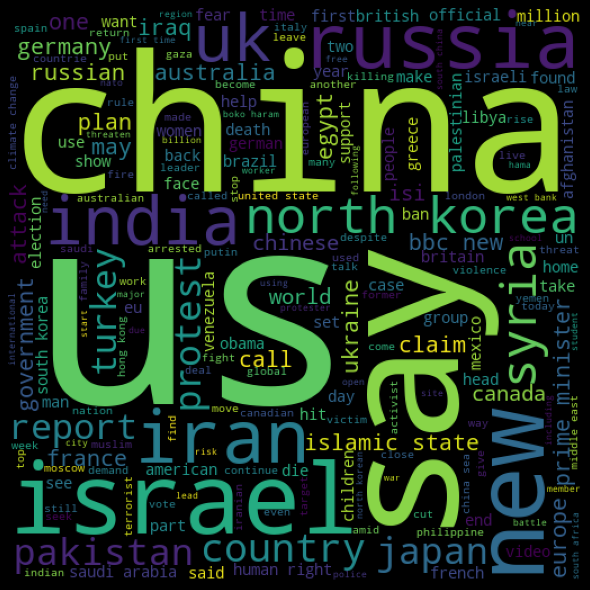

In [907]:
#Wordcloud of not over_18 news
spam_words = ' '.join(list(clean_news[clean_news['over_18'] == 0]['title']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (12, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [908]:
#Making dataset balanced so we can train the model and evaluate it easily
over_18_news = clean_news[clean_news['over_18'] == 1].reset_index(drop=True)
not_over_18_news = clean_news[clean_news['over_18'] == 0].sample(n=320).reset_index(drop=True)
train_data = pd.concat([over_18_news, not_over_18_news])
train_data = train_data[['title', 'over_18']].reset_index(drop=True)
#train_data.describe()

In [909]:
train_data.head()

,title,over_18
0,pics tibetan protests graphic wikileaks,1
1,linked max mosley’s nazistyle sadomasochistic ...,1
2,tabloid horrifies germany poland yellow press ...,1
3,love parade dortmund techno festival breaks re...,1
4,idf kills young palestinian boy potentially nsfw,1


In [1080]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(train_data)):
    news = re.sub('[^a-zA-Z]', ' ', train_data['title'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)#Getting the target variable
train_data['title'] = corpus
y=train_data['over_18'].values

print(train_data)

                                                 title  over_18
0                 pic tibetan protest graphic wikileak        1
1    link max mosley nazistyl sadomasochist sex org...        1
2    tabloid horrifi germani poland yellow press tu...        1
3    love parad dortmund techno festiv break record...        1
4          idf kill young palestinian boy potenti nsfw        1
..                                                 ...      ...
635  venezuela bridg diplomat fissur polish allianc...        0
636  north korean leader kim jongun sudden execut u...        0
637  syria civil war presid bashar alassad join ins...        0
638                nato raid accid kill afghan soldier        0
639  mysteri dead creatur found near leningrad nucl...        0

[640 rows x 2 columns]


In [1327]:
#Splitting dataset into trainig and testing data
title_train, title_test, y_train, y_test = train_test_split(train_data['title'], y, test_size = 0.2, shuffle = True, random_state = 11)

In [1328]:
#Generating tfidif matrix
tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(corpus) * 5, ngram_range=(1,3))
tfidf_vectorizer.fit(title_train)
X_train = tfidf_vectorizer.transform(title_train)
X_test = tfidf_vectorizer.transform(title_test)



Multinomial Naive Bayes

In [1329]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [1330]:
y_predict = clf.predict(X_test)
clf.score(X_test, y_test)

0.8046875

In [1331]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        56
           1       0.83      0.82      0.83        72

    accuracy                           0.80       128
   macro avg       0.80      0.80      0.80       128
weighted avg       0.81      0.80      0.80       128



Logisitic Regression

In [1332]:
LR = LogisticRegression(C=5.0, penalty='l2', tol=0.01)
LR.fit(X_train, y_train)

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [1333]:
y_predict = LR.predict(X_test)
LR.score(X_test, y_test)

0.84375

In [1334]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        56
           1       0.93      0.78      0.85        72

    accuracy                           0.84       128
   macro avg       0.85      0.85      0.84       128
weighted avg       0.86      0.84      0.84       128



Support Vector Machine

In [1335]:
SVM = svm.SVC()
SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1336]:
y_predict = SVM.predict(X_test)
SVM.score(X_test, y_test)

0.8203125

In [1337]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82        56
           1       0.92      0.75      0.82        72

    accuracy                           0.82       128
   macro avg       0.83      0.83      0.82       128
weighted avg       0.84      0.82      0.82       128



Random Forest

In [1338]:
rfc = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', n_estimators = 50)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [1339]:
y_predict = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.78125

In [1340]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79        56
           1       0.94      0.65      0.77        72

    accuracy                           0.78       128
   macro avg       0.81      0.80      0.78       128
weighted avg       0.83      0.78      0.78       128



K-Nearest Neighbor

In [1341]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='distance')

In [1342]:
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.765625

In [1343]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75        56
           1       0.82      0.75      0.78        72

    accuracy                           0.77       128
   macro avg       0.76      0.77      0.76       128
weighted avg       0.77      0.77      0.77       128



Stochastic Gradient Descent 

In [1344]:
sgd = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 )
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=10, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [1345]:
y_predict = sgd.predict(X_test)
sgd.score(X_test, y_test)

0.7734375

In [1346]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76        56
           1       0.84      0.74      0.79        72

    accuracy                           0.77       128
   macro avg       0.77      0.78      0.77       128
weighted avg       0.78      0.77      0.77       128



Deep Learning Models

In [1347]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [1348]:
X_train.sort_indices()
X_test.sort_indices()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                80025     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 80,051
Trainable params: 80,051
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7656


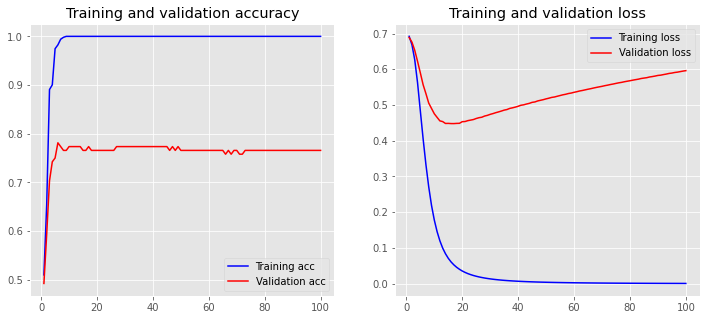

In [1351]:
#training simple neural network using sequential dense layer
input_dim = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(25, input_dim = input_dim, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=16)
clear_session() #important to clear trained weights before fitting model again

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 10-20 epochs in this training.

**Word Embedding**

In [1352]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(title_train)

X_train = tokenizer.texts_to_sequences(title_train)
X_test = tokenizer.texts_to_sequences(title_test)
vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index


In [1353]:
#the tokenizer we generated has different lengths therefore we need to pad 0 and make each vector of same length
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**Keras Embedding Layer**
Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
*   input_dim: the size of the vocabulary
*   output_dim: the size of the dense vector
*   input_length: the length of the sequence







Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          220200    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 222,241
Trainable params: 222,241
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8438


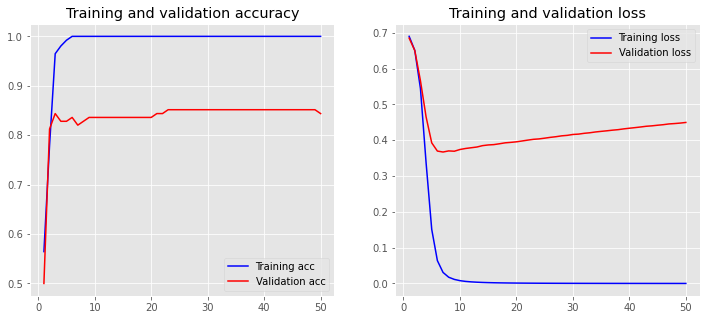

In [1361]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
clear_session()

Significant improvement compared to eariler simple neural network. From the training and validation loss diagram we can stop process around 6-10 epochs to prevent overfitting.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          220200    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 222,241
Trainable params: 222,241
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8594


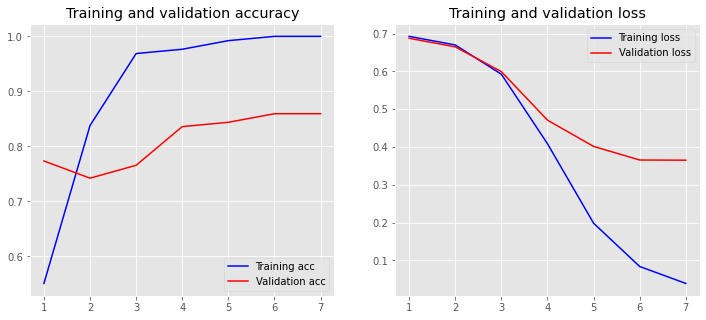

In [1377]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=7,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
clear_session()

**Convolutional Neural Networks (CNN)**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          220200    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                3225      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 287,579
Trainable params: 287,579
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7969


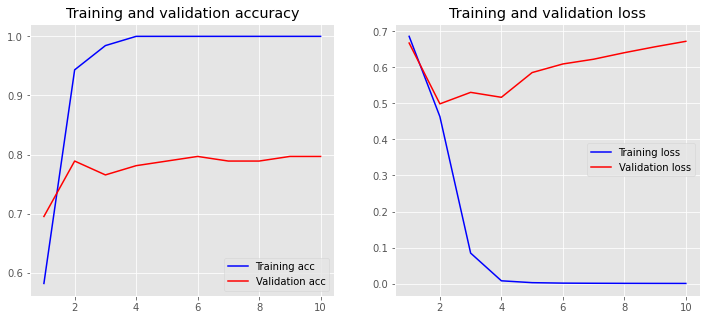

In [1381]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
clear_session()

From above training and validation loss diagram we can stop learning process at 3 epoch to prevent overfitting.

CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.


**Conclusions:**

I tried to do analysis of features using visualization and trained model using tradition and deep learning algorithms. I observered that over the years online news posting is increasing, I found that posting around 11 A.M time would be good for posting the news article. Also I found that US, China, North Korea is the most talked countries in the news. There were lot of terror news mentioned in this 8 years.
I trained model for classifying news is over_18 or not. I used traditional algorithms and among that Multinomial NB, SVM, Random Forest were better and stable. To increase the accuarcy I trained deep neural nets using word embeddings. And I was able to cross 85% accuracy.

**What else we can do in future:**

*   Doing feature extraction and visualization based on authors and finding which authors has highest post, highest average upvotes etc. 
*   We can do topic modeling using K-means clustering to form clusters of similar news and categories each clusters like terror, economy, sports, etc. 
*   We can use title, author, upvotes attributes to train a model to predict if the news will be popular(lets say >25 upvotes) or not.

